# **Project: Amazon Product Recommendation System**

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Installing surprise Library on Google Colab**

In [1]:
!pip install surprise

**Mounting Google Drive on Google Colab**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Import Libraries**

In [3]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

from surprise import accuracy
from surprise.model_selection import GridSearchCV, train_test_split
from surprise.dataset import Dataset
from surprise.reader import Reader
from surprise.prediction_algorithms.knns import KNNBasic
from surprise.prediction_algorithms.matrix_factorization import SVD

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

## **Import and Review Data**

In [4]:
amazon_df = pd.read_csv('/content/drive/MyDrive/MIT_Course/Recommendation_Systems/ProjectAssessment_Amazon_Product_Recom_Sys/ratings_Electronics.csv', header=None)
amazon_df.head()

,0,1,2,3
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


**Observation**
- The dataset doesn't have column names. Let's add proper column names to the dataset.

In [5]:
amazon_df.columns = ['user_id', 'prod_id', 'rating', 'timestamp']
amazon_df.head()

,user_id,prod_id,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


- We won't use the timestamp column in this study, so let's drop it.

In [6]:
amazon_df.drop('timestamp', axis=1, inplace=True)

In [7]:
df_copy = amazon_df.copy()

In [8]:
amazon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   prod_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


**Observations:**
- The dataset has 7,824,482 data points, three columns, one numerical, and two object types.
- This is a large dataset, and it will take a very long time to build a model with this amount of data in my machine or Google Colab. To make this project computationally feasible, I will reduce the size of my dataset.
- Reducing the size of the dataset not only makes it more computationally efficient it also prevents bad recommendations due to limited prior information.
- Many users, in reality, rated very few products, and many products have very few ratings; we can reduce the dataset by adding limits and only keep users that rated a minimum amount of products and products with a minimum number of ratings.
- Users should have rated at least 50 products, and products should have at least 5 ratings to stay in the dataset.

### **Reducing Size of Dataset**

In [9]:
min_user_rating = 50
df1 = amazon_df[amazon_df['user_id'].map(amazon_df['user_id'].value_counts()) >= min_user_rating]

In [10]:
df1.shape

(125871, 3)

In [11]:
df1.user_id.value_counts()

user_id
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
                 ... 
AOQLV2LSI9B2W      50
A2JRDFIGWTX50J     50
A3EHJ5519LG7TR     50
A3LSEIG2PIJYBL     50
A3BY5KCNQZXV5U     50
Name: count, Length: 1540, dtype: int64

**Observations:**
- Most of the users in this dataset rated less than 50 products, and, using the above limit, already decreased the dataset size from ~7.8 M to ~125 K.
- As you can see, all the users in the new dataset have at least 50 ratings.

In [12]:
min_prod_rating = 5
df = df1[df1['prod_id'].map(df1['prod_id'].value_counts()) >= min_prod_rating]

In [13]:
df.shape

(65290, 3)

In [14]:
df.user_id.value_counts()

user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
                 ... 
A16CVJUQOB6GIB      2
A2BGZ52M908MJY      2
A3DL29NLZ7SXXG      1
AP2NZAALUQKF5       1
A3MV1KKHX51FYT      1
Name: count, Length: 1540, dtype: int64

**Observations:**
- The dataset size is reduced to 65,290 data points, which is feasible to model with our computational power.
Note that now we have users with one rating in the dataset. This is because products with less than 5 ratings were eliminated from the dataset, and as a result, users' ratings dropped. Now, the minimum number of ratings by users is one.

## **Exploratory Data Analysis**

**Shape of Dataset**

In [15]:
rows, columns = df.shape

print(f'Number of rows:{rows}')
print(f'Number of columns:{columns}')

Number of rows:65290
Number of columns:3


**Observations:**
- As mentioned above, the current dataset size that we will work with has 65,290 data points and 3 columns.
- This is 0.83% of the original dataset size. Indicating that there were a lot of products and users in the dataset that didn't have a minimum number of ratings and rated a minimum number of products, respectively.

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


In [17]:
df.dtypes

user_id     object
prod_id     object
rating     float64
dtype: object

As mentioned above, the product and user ID are object types, and the rating is float.

In [18]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,65290.0,4.294808,0.988915,1.0,4.0,5.0,5.0,5.0


- Mean rating is 4.29 with a minimum rating of 1.0 and max rating of 5.0
- Note that the Median is 5.0, indicating that the data is skewed toward high ratings.

#### **Missing Values**

In [19]:
df.isnull().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

In [20]:
df.groupby(['user_id', 'prod_id']).count()

rating
user_id        prod_id           
A100UD67AHFODS B00004Z5M1       1
               B0001D3K8A       1
               B000233WJ6       1
               B0002KVQBA       1
               B0002SQ2P2       1
...                           ...
AZOK5STV85FBJ  B005PQTYHE       1
               B006MPRFJQ       1
               B00AANMVNQ       1
               B00B25P27S       1
               B00FB2XNCE       1

[65290 rows x 1 columns]

In [21]:
df.groupby(['user_id', 'prod_id'])['rating'].count().sum()

65290

**Observations:**
- No missing values in the dataset.
- The sum equals the total number of observations, indicating only one interaction between a pair of product and a user.

#### **Summary Statistics**

**RATING**

In [22]:
df['rating'].value_counts()

rating
5.0    36315
4.0    18127
3.0     6481
2.0     2515
1.0     1852
Name: count, dtype: int64

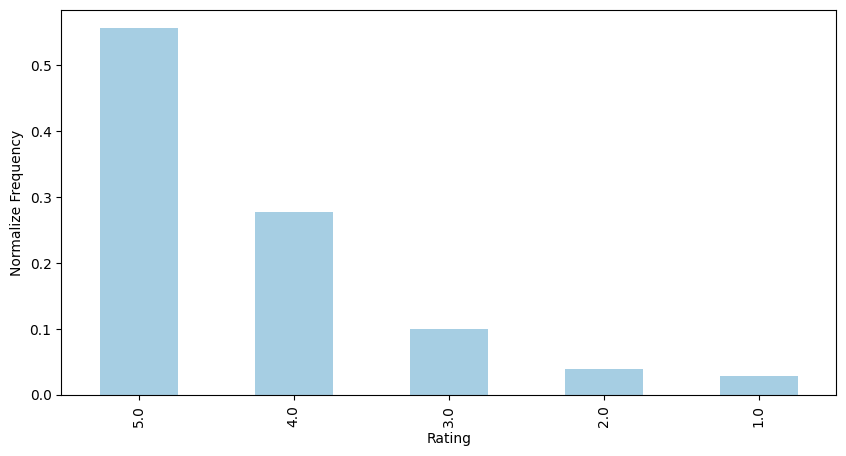

In [23]:
plt.figure(figsize=(10,5 ))
df.rating.value_counts(normalize=True).plot(kind='bar', colormap='Paired')
plt.xlabel('Rating')
plt.ylabel('Normalize Frequency')
plt.show()

**Observations:**
The number of ratings decreases as you go from 5 to 1.
- ~55% of the ratings are 5, ~27% of them are 4, and ~10% of ratings are 3.
- Less than 7% of total ratings are 1 and 2, indicating that users who didn't like the product probably didn't share that with Amazon, and most of the time, people who liked a product would leave the review.

**USERS**

In [24]:
df['user_id'].nunique()

1540

In [25]:
df['user_id'].value_counts()

user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
                 ... 
A16CVJUQOB6GIB      2
A2BGZ52M908MJY      2
A3DL29NLZ7SXXG      1
AP2NZAALUQKF5       1
A3MV1KKHX51FYT      1
Name: count, Length: 1540, dtype: int64

**Observations:**
- There are 1540 unique users in this dataset.
- The user with the highest rating is `ADLVFFE4VBT8` with a 295 rating.

**PRODUCTS**

In [26]:
df['prod_id'].nunique()

5689

In [27]:
df['prod_id'].value_counts()

prod_id
B0088CJT4U    206
B003ES5ZUU    184
B000N99BBC    167
B007WTAJTO    164
B00829TIEK    149
             ... 
B00368CDH6      5
B0036AZA6A      5
B0036E8V08      5
B0036QL1JY      5
B00LGQ6HL8      5
Name: count, Length: 5689, dtype: int64

**Observations:**
- There are 5689 unique products in this dataset.
- For 1540 unique users and 5689 unique products, there is a possibility of 8,761,060 rating but we only have 65,290 rating. Only 0.7% of user-item interaction matrix is filled with data. We need to predict rating for the rest of the matrix.
- Product `B0088CJT4U` has the highest number of ratings (206). But still, there is a possibility of 1540-206 = 1334 more interactions as we have 1540 unique users in our datasets. For those 1334 remaining users, we can build a recommendation system to predict who is most likely to interact with the item.

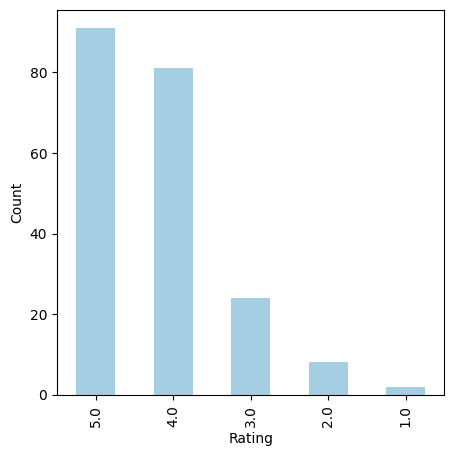

In [28]:
plt.figure(figsize=(5,5))
df[df['prod_id'] == 'B0088CJT4U']['rating'].value_counts().plot(kind='bar', colormap='Paired')
plt.ylabel('Count')
plt.xlabel('Rating')
plt.show()

- The B0088CJT4U product has been liked by the majority of the users, with most of the ratings being 4 or 5 and very few 1 and 2 ratings.

**User-Item Interactions**

In [29]:
prod_interaction = df.groupby('user_id')['prod_id'].count()
prod_interaction

user_id
A100UD67AHFODS     53
A100WO06OQR8BQ     77
A105S56ODHGJEK     58
A105TOJ6LTVMBG     32
A10AFVU66A79Y1     47
                 ... 
AZBXKUH4AIW3X      22
AZCE11PSTCH1L      23
AZMY6E8B52L2T     105
AZNUHQSHZHSUE      30
AZOK5STV85FBJ      14
Name: prod_id, Length: 1540, dtype: int64

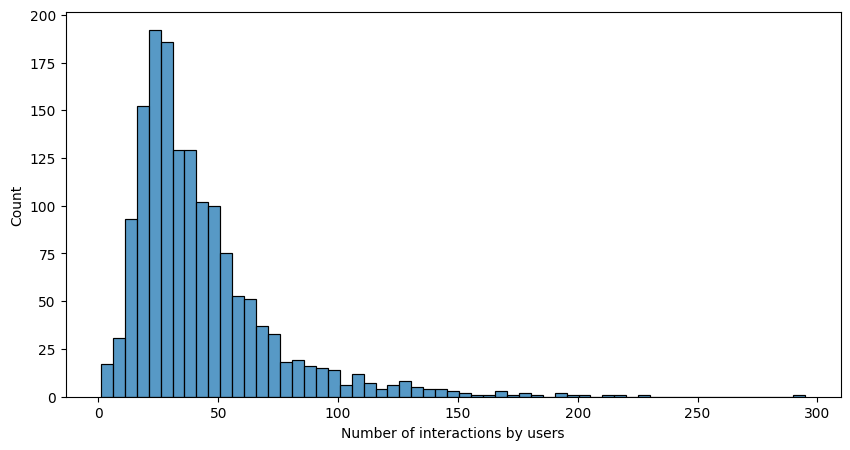

In [30]:
plt.figure(figsize=(10,5))
sns.histplot(prod_interaction)
plt.xlabel('Number of interactions by users')
plt.show()

- The distribution of user-item interaction in this dataset is plotted. The distribution is highly right-skewed. Only a few users interacted with more than 100 products.

## **Building Models**

### **Model 1: Ranked-Based Recommendation System**

In [31]:
avg_rating = df.groupby('prod_id')['rating'].mean()
rating_count = df.groupby('prod_id')['rating'].count()

ranking_df = pd.DataFrame({'avg_rating': avg_rating,
                          'rating_count': rating_count})
ranking_df.head()

,avg_rating,rating_count
prod_id,,
1400501466,3.333333,6
1400532655,3.833333,6
1400599997,4.000000,5
9983891212,4.875000,8
B00000DM9W,5.000000,5


In [32]:
def ranking_recommendation(data, top_n, min_interaction):
    recommend = data[data['rating_count'] > min_interaction].sort_values(by = 'avg_rating', ascending=False)
    return recommend.index[:top_n]

**Recommending top 5 products with 50 minimum interactions based on popularity**

In [33]:
list(ranking_recommendation(ranking_df, 5, 50))

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

**Recommending top 5 products with 100 minimum interactions based on popularity**

In [34]:
list(ranking_recommendation(ranking_df, 5, 100))

['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']

### **Similarity-Based Collaborative Filtering Recommendation System**

We only need a user-item interaction matrix to build the model in Collaborative Filtering recommendation systems.

Before starting, let's go over basic terminologies:

`Relevant Product`: A product that is actually rated higher than the threshold rating is relevant. <br>
`Recommended Product`: A product with a predicated rating higher than the threshold is a recommended product. <br>
<br>
`False Negative (FN)`: Frequency of relevant products not recommended to the user. Since these products are not recommended to the user, they might not buy the product, which is **opportunity loss** for the service provider. <br>
`False Positive (FP)`: Frequency of recommended products that are not actually relevant. The recommendation system is not doing a good job of finding and recommending relevant products to the user, which is **resource loss** for the service provider.

`Recall`: Fraction of actually relevant products that are recommended to the user. <br>
`Precision`: Fraction of recommended products that are relevant actually.

Since in the recommendation system usually, the few initial recommendations matter more than others, the below metrics are defined to find the performance on top k recommendations: <br>

`Precision@k`: Fraction of recommended products that are relevant in top k predictions. <br>
`Recall@k`: Fraction of actually relevant products that are recommended to the user in top k predictions. <br>
`F1-Score@k`: it is a harmonic mean of precisio@k and recall@k. Used when precision and recall are both important. <br>

-Let's define a function to calculate the `Precision@k`, `Recall@k`, and `F1-Score@k`:


In [35]:
def performance_metric(model, data, k, threshold):
    user_pred_true = defaultdict(list)
    predictions = model.test(data)
    for u_id, _, y_true, est, _ in predictions:
        user_pred_true[u_id].append((est, y_true))

    precisions = dict()
    recalls = dict()

    for u_id, user_rating in user_pred_true.items():
        user_rating.sort(key = lambda x: x[0], reverse= True)
        num_recom_prod_k = sum((est >= threshold) for (est, y_true) in user_rating[:k]) # number of recoommended prodcuts in top k
        num_relevant_prod= sum((y_true >= threshold) for (est, y_true) in user_rating) # number of relevant prodcuts
        num_relevant_recom_prod_k = sum(((y_true >= threshold) and (est >= threshold)) for (est,y_true) in user_rating[:k]) # number of recoommended and relevant prodcuts in top k

        precisions[u_id] = num_relevant_recom_prod_k / num_recom_prod_k if num_recom_prod_k !=0 else 0
        recalls[u_id] = num_relevant_recom_prod_k / num_relevant_prod if num_relevant_prod !=0 else 0

    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)
    print(f'Precision@{k}: {precision}')
    print(f'Recall@{k}: {recall}')
    print(f'F1-score@{k}: {round((2*precision*recall)/(precision+recall), 3)}')

- For this project we use:<br>
`threshold = 3.5`<br>
`k = 10`

#### **Data Preparation**

- We can also transform user_id and prod_id using labelEncoder, but since information about specific users and products was requested later, we decided not to do it. Of course, we can find the equivalent of those user_id and prod_id in the encoded dataset, but for simplicity, we will avoid that in this study.  
- Converting the dataset from pandas DataFrame format to surprise.dataset.Dataset, which is required when working with the surprise library.

In [36]:
reader = Reader(rating_scale = (0, 5))
data = Dataset.load_from_df(df[['user_id', 'prod_id', 'rating']], reader)

train_set, test_set = train_test_split(data, test_size = 0.2, random_state = 42)

#### **Model 2: User-user Similarity-based Collaborative Filtering Recommendation System**

- Using KNNBasic for this method.

In [37]:
sim_options = {'name': 'cosine',
               'user_based': True}

user_user_sim = KNNBasic(sim_options = sim_options, verbose = True, random_state = 1)

user_user_sim.fit(train_set)

performance_metric(user_user_sim, test_set, 10, 3.5)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0012
Precision@10: 0.855
Recall@10: 0.858
F1-score@10: 0.856


**Observations:**
- This model's RMSE (root mean square error) is 1.0012.
- The precision in the top 10 recommendations is 0.855, meaning that 85.5% of the recommended products are relevant in the top 10 recommendations.
- The recall in the top 10 recommendations is 0.858, meaning that 85.8% of the actually relevant products are recommended in the top 10 recommendations.
- The f1-score is 0.856

**Predict rating** for `userId=A3LDPF5FMB782Z` and `productId=1400501466`. As shown, below the true rating for this product and user in the dataset is 5.0

In [38]:
df[(df['user_id'] == 'A3LDPF5FMB782Z') & (df['prod_id'] == '1400501466')]

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0


In [39]:
user_user_sim.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.40   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.4, details={'actual_k': 5, 'was_impossible': False})

- The predicted rating for this user, product combination, is 3.4, while the actual rating is 5.
- The model has a 1.6-point error for this specific user-product rating.

Let's find a list of users that have no rating for `product_id = 1400501466`

In [40]:
df[df['prod_id'] != '1400501466'].user_id.unique()

array(['A2ZR3YTMEEIIZ4', 'A3CLWR1UUZT6TG', 'A5JLAU2ARJ0BO', ...,
       'A215WH6RUDUCMP', 'A38C12950IM24P', 'A2J4XMWKR8PPD0'], dtype=object)

In [41]:
df[(df['user_id'] == 'A34BZM6S9L7QI4') & (df['prod_id'] == '1400501466')]

,user_id,prod_id,rating


**Perdict rating** for  `userId=A34BZM6S9L7QI4` and `productId=1400501466` which no rating is available between them.

In [42]:
user_user_sim.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

- The model predicted that user_id = A34BZM6S9L7QI4 will rate product_id = 1400501466 4.29.
- Let's improve the base model's performance by doing hyperparameter tuning.

#### **Model 3: User-user Similarity-based Recommendation System - Hyperparameter Tuning**

Hyperparameters for KNNBasic algorithm are:
- k --> Maximum number of neighbors to take into account for aggregation. Default k = 40
- min_k --> Minimum number of neighbors to take into account for aggregation. Default min_k = 1
- sim_options:
    - Similarity measures:
        `cosine` - Compute the cosine similarity between all pairs of users.

        `msd` - Compute the Mean Squared Difference similarity between all pairs of users.

        `pearson` - Compute the Pearson correlation coefficient between all pairs of users.

        `pearson_baseline` - Compute the (shrunk) Pearson correlation coefficient between all pairs of users using baselines for centering instead of means.
    - min_support --> min number of common items for similarity not to be zero.

In [43]:
param_grid_uu = {'sim_options': {'name':['msd', 'cosine', 'pearson', 'pearson_baseline'],
                                 'user_based': [True]} ,
                 'k': [10, 20 , 30, 40],
                 'min_k' : [2, 3, 4, 6, 9]}


user_user_sim_tune = GridSearchCV(KNNBasic, param_grid_uu, measures= ['rmse'], cv=3, n_jobs=-1)
user_user_sim_tune.fit(data)
print(user_user_sim_tune.best_score['rmse'])
print(user_user_sim_tune.best_params['rmse'])

0.9725463984866752
{'sim_options': {'name': 'cosine', 'user_based': True}, 'k': 40, 'min_k': 4}


- Let's build a model using the tuned hyperparameters.

In [44]:
sim_options = {'name': 'cosine',
               'user_based': True}

user_user_sim_optimized = KNNBasic(sim_options = sim_options, k = 40, min_k = 4, random_state = 1, verbose = True)
user_user_sim_optimized.fit(train_set)

performance_metric(user_user_sim_optimized, test_set, 10, 3.5)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9511
Precision@10: 0.853
Recall@10: 0.889
F1-score@10: 0.871


**Observations:**
- The RMSE decreased to 0.9511 in the optimized model compared to the base model. ~5% drop in the RMSE.
- The precision in the top 10 recommendations is 0.853, dropping slightly compared to the base model.
- The recall in the top 10 recommendations is 0.889, an increase from the base model.
- The f1-score is 0.871, showing improvement compared to the base model.
- Overall, the tuned model performs better than the base model.

**Predict rating** for `userId=A3LDPF5FMB782Z` and `productId=1400501466`. As shown, below the true rating for this product and user in the dataset is 5.0

In [45]:
user_user_sim_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.40   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.4, details={'actual_k': 5, 'was_impossible': False})

- The predicted rating for this user, product combination, is 3.4, while the actual rating is 5.

**Perdict rating** for  `userId=A34BZM6S9L7QI4` and `productId=1400501466` which no rating is available between them.

In [46]:
user_user_sim_optimized.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

- The model predicted that user_id = A34BZM6S9L7QI4 will rate product_id = 1400501466 4.29.

#### **Identifying similar users**

The below code will provide the nearest neighbor (similar users to a given user) based on this KNNBasic algorithm. We are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [47]:
user_user_sim_optimized.get_neighbors(0, 5)

[6, 7, 17, 26, 32]

#### **Implement Recommendation Algorithm Based on Tunned User-user Based Similiarity Model**

In [48]:
def get_recommendation(model, data, user_id, top_n):
    recommendation = []
    user_item_inter_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')
    non_inter_prod = user_item_inter_matrix.loc[user_id][user_item_inter_matrix.loc[user_id].isnull()].index.tolist()
    for prod_id in non_inter_prod:
        est_prod_score = model.predict(user_id, prod_id).est
        recommendation.append((prod_id, est_prod_score))
    recommendation.sort(key = lambda x: x[1], reverse=True)
    return recommendation[:top_n]

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with user-user similarity-based recommendation system**

In [49]:
recom_uu = get_recommendation(user_user_sim_optimized, df, 'A3LDPF5FMB782Z', 5)
pd.DataFrame(recom_uu, columns = ['prod_id', 'Predicted_rating'])

,prod_id,Predicted_rating
0,B000067RT6,5
1,B0000BZL1P,5
2,B000BQ7GW8,5
3,B000FQ2JLW,5
4,B000M17AVO,5


**Corrected the Recommendation Based on Ranking**

In [50]:
def ranking_user_prod(recommended_prod, ranking_prod):
    prod_rank = ranking_prod.loc[[item[0] for item in recommended_prod]].sort_values('rating_count', ascending = False)[['rating_count']].reset_index()
    prod_rank = prod_rank.merge(pd.DataFrame(recommended_prod, columns=['prod_id', 'Predicted_rating']), on='prod_id', how='inner')
    prod_rank['corrected_rating'] = prod_rank['Predicted_rating'] - 1 / np.sqrt(prod_rank['rating_count'])
    return prod_rank.sort_values(by = 'corrected_rating', ascending = False)

In [51]:
ranking_user_prod(recom_uu, ranking_df)

,prod_id,rating_count,Predicted_rating,corrected_rating
0,B000BQ7GW8,54,5,4.863917
1,B0000BZL1P,44,5,4.849244
2,B000067RT6,41,5,4.843826
3,B000M17AVO,26,5,4.803884
4,B000FQ2JLW,19,5,4.770584


**Observations:**
- The recommended products initially all had a rating of 5. This value rating is corrected using the central limit theorem and based on the number of ratings available for that product. Notice that when the rating is adjusted, the order of recommended products changes.

#### **Model 4: Item-Item Similarity-based Collaborative Filtering Recommendation System**

Let's look at similarity-based collaborative filtering, which calculates similarity between items.

In [52]:
sim_options = {'name': 'cosine',
               'user_based': False}

item_item_sim = KNNBasic(sim_options = sim_options, verbose = True, random_state = 1)

item_item_sim.fit(train_set)

performance_metric(item_item_sim, test_set, 10, 3.5)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9950
Precision@10: 0.838
Recall@10: 0.845
F1-score@10: 0.841


**Observations:**
- The RMSE (root mean square error) is 0.9950 for item-item similarity-based collaborative filtering, which is better than user-user similarity-based baseline
- The precision in the top 10 recommendations is 0.838, slightly lower than the baseline for user-user similarity-based.
- The recall in the top 10 recommendations is 0.845, slightly lower than the baseline for user-user similarity-based.
- The f1-score is 0.841, slightly lower than the baseline of the user-user similarity-based model.

**Predict rating** for `userId=A3LDPF5FMB782Z` and `productId=1400501466`. As shown, below the true rating for this product and user in the dataset is 5.0

In [53]:
item_item_sim.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.27   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.2727272727272725, details={'actual_k': 22, 'was_impossible': False})

- The predicted rating for this user, product combination, is 4.27, while the actual rating is 5. This value is closer to the actual value compared to the previous models.
- The model has a 0.73 point error for this specific user-product rating.  

**Perdict rating** for  `userId=A34BZM6S9L7QI4` and `productId=1400501466` which no rating is available between them.

In [54]:
item_item_sim.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

- The model predicted that user_id = A34BZM6S9L7QI4 will rate product_id = 1400501466, 4.29.
- Let's improve the base model's performance by doing hyperparameter tuning.

#### **Model 5: Item-item Similarity-based Recommendation System - Hyperparameter Tuning**

In [55]:
param_grid_ii = {'sim_options': {'name':['msd', 'cosine', 'pearson', 'pearson_baseline'],
                                 'user_based': [False]} ,
                 'k': [10, 20 , 30],
                 'min_k' : [3, 6, 9]}


item_item_sim_tune = GridSearchCV(KNNBasic, param_grid_ii, measures= ['rmse'], cv=3, n_jobs=-1)
item_item_sim_tune.fit(data)
print(item_item_sim_tune.best_score['rmse'])
print(item_item_sim_tune.best_params['rmse'])

0.9751007465159834
{'sim_options': {'name': 'msd', 'user_based': False}, 'k': 20, 'min_k': 6}


- Let's build a model using the tuned hyperparameters.

In [56]:
sim_options = {'name': 'msd',
               'user_based': False}

item_item_sim_optimized = KNNBasic(sim_options = sim_options, k = 20, min_k = 6, random_state = 1, verbose = True)
item_item_sim_optimized.fit(train_set)

performance_metric(item_item_sim_optimized, test_set, 10, 3.5)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9578
Precision@10: 0.839
Recall@10: 0.88
F1-score@10: 0.859


**Observations:**
- The RMSE dropped to 0.9578 from 0.9950 compared to the item-item sim-based baseline model.
- The precision in the top 10 recommendations is 0.839, similar to the item-item sim-based baseline model.
- The recall in the top 10 recommendations is 0.88, an increase from the base model.
- The f1-score is 0.859, showing improvement compared to the base model.
- Overall, the optimized model performance improved compared to the baseline item-item sim-based model.

**Predict rating** for `userId=A3LDPF5FMB782Z` and `productId=1400501466`. As shown, below the true rating for this product and user in the dataset is 5.0

In [57]:
item_item_sim_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.71   {'actual_k': 20, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.7105263157894735, details={'actual_k': 20, 'was_impossible': False})

- The predicted rating for this user, product combination, is 4.71 while the actual rating is 5 which is very close to each other.

**Perdict rating** for  `userId=A34BZM6S9L7QI4` and `productId=1400501466` which no rating is available between them.

In [58]:
item_item_sim_optimized.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

- The model predicted that user_id = A34BZM6S9L7QI4 will rate product_id = 1400501466 4.29.

#### **Identifying Similar Items**

The below code will provide the nearest neighbor (similar items to a given itesm) based on above optimized KNNBasic algorithm. We are finding the 5 most similar items to the first item in the list with internal id 0, based on the `msd` distance metric.

In [59]:
item_item_sim_optimized.get_neighbors(0, 5)

[29, 53, 67, 106, 151]

#### **Recommendation Based on Tunned Item-item Similiarity-based Model**

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with item-item based similarity recommendation system**

In [60]:
recom_ii = get_recommendation(item_item_sim_optimized, df, 'A1A5KUIIIHFF4U', 5)
pd.DataFrame(recom_ii, columns = ['prod_id', 'Predicted_rating'])

,prod_id,Predicted_rating
0,1400532655,4.292024
1,1400599997,4.292024
2,9983891212,4.292024
3,B00000DM9W,4.292024
4,B00000J1V5,4.292024


**Correcting the Recommendation Based on Ranking**

In [61]:
ranking_user_prod(recom_ii, ranking_df)

,prod_id,rating_count,Predicted_rating,corrected_rating
0,9983891212,8,4.292024,3.938471
1,B00000J1V5,7,4.292024,3.914060
2,1400532655,6,4.292024,3.883776
3,1400599997,5,4.292024,3.844810
4,B00000DM9W,5,4.292024,3.844810


**Observations:**
The product recommended originally had a rating of around 4.29. The rating values are corrected using the central limit theorem and based on the number of ratings available for that product. Notice that when the rating is adjusted, the order of recommended products changes.

### **Model-Based Collaborative Filtering Recommendation System (Matrix Factorization)**

In this method, we only need a user-item interaction matrix and will use latent features to find recommendations for each user.

#### **Model 6: Singular Value Decomposition (SVD)**

In [62]:
svd_model = SVD(random_state = 1)
svd_model.fit(train_set)

performance_metric(svd_model, test_set, 10, 3.5)

RMSE: 0.8882
Precision@10: 0.853
Recall@10: 0.88
F1-score@10: 0.866


**Observations:**
- The RMSE (root mean square error) is 0.8882, the lowest among all the models built.
- The precision in the top 10 recommendations is 0.853, meaning that 85.3% of the recommended products are relevant in the top 10 recommendations.
- The recall in the top 10 recommendations is 0.88, meaning that 88% of the actually relevant products are recommended in the top 10 recommendations.
- The f1-score is 0.866

**Predict rating** for `userId=A3LDPF5FMB782Z` and `productId=1400501466`. As shown, below the true rating for this product and user in the dataset is 5.0

In [63]:
svd_model.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.08   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.081406749810685, details={'was_impossible': False})

- The predicted rating for this user, product combination, is 4.08 while the actual rating is 5.

**Perdict rating** for  `userId=A34BZM6S9L7QI4` and `productId=1400501466` which no rating is available between them.

In [64]:
svd_model.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.40   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.40037568046934, details={'was_impossible': False})

- The model predicted that user_id = A34BZM6S9L7QI4 will rate product_id = 1400501466 4.40.
- Let's improve the base model's performance by doing hyperparameter tuning.

#### **Model 7: Singular Value Decomposition (SVD) - Hyperparameter Tuning**

There are lots of parameters to tune for the SVD model. Out of all of them, we will tune only `n_epochs`, `Ir_all`, and `reg_all`:
- `n_epochs`: The number of iterations of the SGD algorithm.
- `Ir_all`: The learning rate for all parameters.
- `reg_all`: The regularization term for all parameters.

In [65]:
param_grid_svd= {'n_epochs': [10, 20, 30],
                 'lr_all': [0.001, 0.005, 0.01],
                 'reg_all': [0.2, 0.4, 0.6]}

svd_tune = GridSearchCV(SVD, param_grid_svd, measures= ['rmse'], n_jobs=-1, cv=3)

svd_tune.fit(data)
print(svd_tune.best_score['rmse'])
print(svd_tune.best_params['rmse'])

0.8974619156338273
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


- Let's build a model using the tuned hyperparameters.

In [66]:
svd_optimized = SVD(random_state = 1, n_epochs = 20, lr_all = 0.01, reg_all = 0.2)
svd_optimized.fit(train_set)

performance_metric(svd_optimized, test_set, 10, 3.5)

RMSE: 0.8808
Precision@10: 0.854
Recall@10: 0.878
F1-score@10: 0.866


**Observations:**
- The RMSE (root mean square error) is 0.8808 very small drop from the baseline SVD model.
- The precision in the top 10 recommendations is 0.854, slightly higher than the baseline SVD model.
- The recall in the top 10 recommendations is 0.878, slightly higher than the baseline SVD model.
- The f1-score is 0.866.
- Overall, the optimized model didn't improve the performance of the baseline SVD model.

**Predict rating** for `userId=A3LDPF5FMB782Z` and `productId=1400501466`. As shown, below the true rating for this product and user in the dataset is 5.0

In [67]:
svd_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.13   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.128589011282042, details={'was_impossible': False})

- The predicted rating for this user, product combination, is 4.13 while the actual rating is 5.

**Perdict rating** for  `userId=A34BZM6S9L7QI4` and `productId=1400501466` which no rating is available between them.

In [68]:
svd_optimized.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.22   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.216280997100113, details={'was_impossible': False})

- The model predicted that user_id = A34BZM6S9L7QI4 will rate product_id = 1400501466 4.22.

#### **Recommendation Based on Tunned SVD Model**

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with Matrix Factorization recommendation system**

In [69]:
recom_svd = get_recommendation(svd_optimized, df, 'A1A5KUIIIHFF4U', 5)
pd.DataFrame(recom_svd, columns = ['prod_id', 'Predicted_rating'])

,prod_id,Predicted_rating
0,B00AR95ESC,4.200191
1,B000JV9LUK,4.198581
2,B002M3SOCE,4.182910
3,B000PEF254,4.181580
4,B00HG1L334,4.172999


In [70]:
ranking_user_prod(recom_svd, ranking_df)

,prod_id,rating_count,Predicted_rating,corrected_rating
0,B00HG1L334,16,4.172999,3.922999
1,B000JV9LUK,10,4.198581,3.882353
2,B00AR95ESC,9,4.200191,3.866858
3,B002M3SOCE,8,4.182910,3.829356
4,B000PEF254,7,4.181580,3.803616


## **Conclusion and Recommendations**

- In this case study, we built a recommendation system for the following four models and performed hyperparameter tuning:
    - Ranked-based using average
    - User-User similarity-based collaborative filtering
    - Item-Item similarity-based collaborative filtering
    - Matrix-Factorization Collaborative filtering
<br>
- Collaborative Filtering searches for neighbors based on similarity of item (example) preferences and recommend items that those neighbors interacted while Matrix factorization works by decomposing the user-item matrix into the product of two lower dimensionality rectangular matrices.

- The recommendation systems' performance was evaluated by calculating RMSE, Precision@k, Recall@k, and F1-score@k, where k refers to the top k recommendations.

- Tuned Similarity-Based Collaborative Filtering Models have performed better than their baseline model.

- Overall, `optimized user-user similarity-based collaborative filtering` provides the best performance in terms of F1 Score (0.871).

- The Collaborative Models use the user-item-ratings data to find similarities and make predictions rather than just predicting a random rating based on the distribution of the data. This could a reason why the Collaborative filtering performed well.

- Tuned SVD matrix factorization model is not improving the base line SVD much.  

- The optimized SVD model provides the lowest RMSE (0.8808) because it assumes that both products and users are present in some low dimensional space describing their properties and recommends a product based on its proximity to the user in the latent space. Implying it accounts for latent factors as well.

- For future improvement, we can combine different recommendation techniques to build complex models like hybrid recommendation systems.